# Regression Kriging Model

## setup

In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 500)
# kriging
from pykrige.rk import RegressionKriging
import pykrige.kriging_tools as kt
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from itertools import product
import re


In [2]:
# importing datasets
data_lu = gpd.read_file('..\\output\\data_lu_nr2.GEOJSON', engine='pyogrio')
data_sp = gpd.read_file('..\\output\\data_sp_nr2.GEOJSON', engine='pyogrio')
data_oz = gpd.read_file('..\\output\\data_oz_nr2.GEOJSON', engine='pyogrio')

In [3]:
x_cols = ['maxspeed', 'bridge',
       'junction', 'rt_highway', 'rt_trunk', 'rt_primary', 'rt_secondary',
       'rt_tertiary', 'rt_unclassified', 'rt_residential', 'rt_living_street',
       'rt_busway', 'rt_service', 'dist_to_train', 'dist_to_recreation',
       'landuse_is_residential', 'landuse_is_commercial',
       'landuse_is_industrial', 'building_height']

In [4]:
# utils to fetch only (in)dependent vars
def get_X_arr(df, cols=['maxspeed', 'bridge',
       'junction', 'rt_highway', 'rt_trunk', 'rt_primary', 'rt_secondary',
       'rt_tertiary', 'rt_unclassified', 'rt_residential', 'rt_living_street',
       'rt_busway', 'rt_service', 'dist_to_train', 'dist_to_recreation',
       'landuse_is_residential', 'landuse_is_commercial',
       'landuse_is_industrial', 'building_height']):
    return df[cols].values
def get_y_arr(df, y='dBA_reg'):
    return df[y].values
def get_c_arr(df, c=['x', 'y']):
    return df[c].values

# creating train-test-pred splits
measurement_col = 'dBA_reg'
train_lu, test_lu = train_test_split(data_lu[data_lu[measurement_col].notna()], test_size=0.3)
pred_lu = data_lu[data_lu[measurement_col].isna()]
train_sp, test_sp = train_test_split(data_sp[data_sp[measurement_col].notna()], test_size=0.3)
pred_sp = data_sp[data_sp[measurement_col].isna()]
train_oz, test_oz = train_test_split(data_oz[data_oz[measurement_col].notna()], test_size=0.3)
pred_oz = data_oz[data_oz[measurement_col].isna()]

## Baseline Models

In [5]:
svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]
areas = [('lunetten', train_lu, test_lu, pred_lu, data_lu),
         ('science park', train_sp, test_sp, pred_sp, data_sp),
         ('oud zuilen', train_oz, test_oz, pred_oz, data_oz),]


preds, min_pred, max_pred = {str(m): {} for m in models}, np.inf, -np.inf

for x, m in enumerate(models):
    for y, (area, train_a, test_a, pred_a, data_a) in enumerate(areas):
        print("=" * 40)
        print("regression model:", m.__class__.__name__)
        print(f"area: {area} (y:{y},x:{x})")
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
        m_rk.fit(get_X_arr(train_a), get_c_arr(train_a), get_y_arr(train_a))
        print("Regression Score: ", m_rk.regression_model.score(get_X_arr(test_a), get_y_arr(test_a)))
        print("RK score: ", m_rk.score(get_X_arr(test_a), get_c_arr(test_a), get_y_arr(test_a)))
        pred = m_rk.predict(get_X_arr(data_a), get_c_arr(data_a))
        min_pred = min(min_pred, min(pred)); max_pred = max(max_pred, max(pred))
        preds[str(m)][area] = pred

regression model: SVR
area: lunetten (y:0,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.007670128307502244
RK score:  0.8381885471862309
regression model: SVR
area: science park (y:1,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.01559281097189913
RK score:  0.6991503610489767
regression model: SVR
area: oud zuilen (y:2,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.028106980229889222
RK score:  0.6248668737766201
regression model: RandomForestRegressor
area: lunetten (y:0,x:1)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7834263077221272
RK score:  0.7995023950545274
regression model: RandomForestRegressor
area: science park (y:1,x:1)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6116198774165975
RK score:  0.6592192501038158
regression model: RandomForestRegressor
area: oud zuilen (y:2,

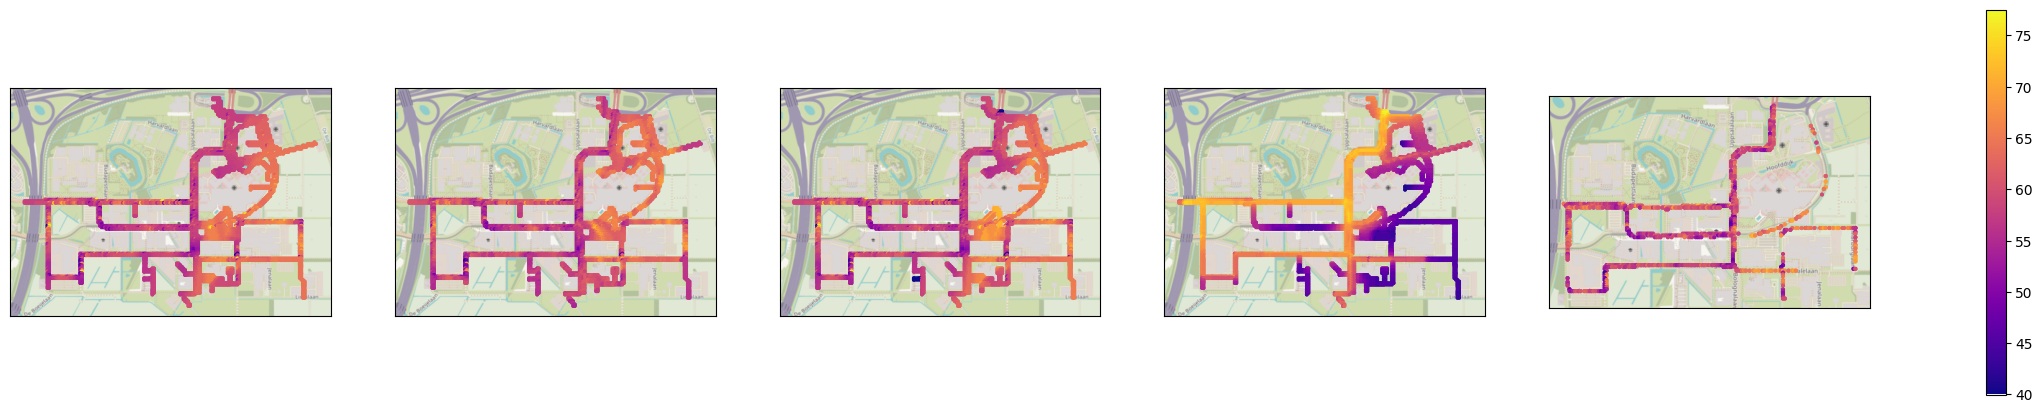

In [6]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,30))
# norm, cmap = mpl.colors.Normalize(vmin=40, vmax=max_pred), 'plasma'
# for x, m in enumerate(models):
#     print(str(m))
#     for y, (area, train_a, test_a, pred_a, data_a) in enumerate(areas):
#         vis_df = gpd.GeoDataFrame(data={'pred': preds[y][x]},
#                                   geometry=data_a['geometry'], crs=data_a.crs)
#         vis_df.plot(column='pred', ax=axs[y][x], markersize=3, norm=norm, cmap=cmap)
#         axs[y][x].set_xticks([]); axs[y][x].set_yticks([])
#         cx.add_basemap(ax=axs[y][x], crs=vis_df.crs, attribution=False)

# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
# fig.show()

area_data = data_sp
area_name = 'science park'
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
norm, cmap = mpl.colors.Normalize(vmin=40, vmax=max_pred), 'plasma'

for x, m in enumerate(models):
    vis_df = gpd.GeoDataFrame(data={'pred': preds[str(m)][area_name]},
                            geometry=area_data['geometry'], crs=area_data.crs)
    vis_df.plot(column='pred', ax=axs[x], markersize=3, norm=norm, cmap=cmap)
    axs[x].set_xticks([]); axs[x].set_yticks([])
    cx.add_basemap(ax=axs[x], crs=vis_df.crs, attribution=False)

area_data.plot(column='dBA_rivm', ax=axs[3], markersize=3, norm=norm, cmap=cmap)
axs[3].set_xticks([]); axs[3].set_yticks([])
cx.add_basemap(ax=axs[3], crs=area_data.crs, attribution=False)

area_data.plot(column='dBA_reg', ax=axs[4], markersize=4, norm=norm, cmap=cmap)
axs[4].set_xticks([]); axs[4].set_yticks([])
cx.add_basemap(ax=axs[4], crs=area_data.crs, attribution=False)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
print()

## Model Selection 

### Spatial K-Fold Setup

In [6]:
# creating spatial groups/clusters within each dataset
def add_spatial_fold_groups(gdf, x_col='x', y_col='y', group_col='group'):
    """ Adds a column with a group_id to the df/gdf, with each group
    being a cluster of points of roughly the same size. Useful for
    spatial k-fold. Creates a total of 16 groups.
    """ # TODO might create better splits using sort -> .iloc splits (will be less efficient though)
    gdf[group_col] = -1
    s2 = gdf[x_col].median() # create a split on x
    s1, s3 = gdf[gdf[x_col] < s2][x_col].median(), gdf[gdf[x_col] >= s2][x_col].median()
    group_id = 0
    pxs = -np.inf
    for xs in (s1, s2, s3, np.inf):
        g = gdf[gdf[x_col] < xs]
        ys2 = g[y_col].median() # for each x split, create a split on y
        ys1, ys3 = g[g[y_col] < ys2][y_col].median(), g[g[y_col] >= ys2][y_col].median()
        pys = -np.inf
        for ys in (ys1, ys2, ys3, np.inf): # for each split assign group_id
            gdf.loc[(pxs < gdf[x_col]) & (gdf[x_col] <= xs) & 
                    (pys < gdf[y_col]) & (gdf[y_col] <= ys), group_col] = group_id
            pys = ys; group_id += 1
        pxs = xs
    return gdf

train_lu = add_spatial_fold_groups(train_lu.reset_index())
train_sp = add_spatial_fold_groups(train_sp.reset_index())
train_oz = add_spatial_fold_groups(train_oz.reset_index())

In [ ]:
# from sklearn.model_selection import GroupKFold, cross_val_predict


# cities = df['city'].values
# group_kfold = GroupKFold(n_splits=5) # Generator for the train/test indices
# city_kfold = group_kfold.split(X, y, cities)  # Create a nested list of train and test indices for each fold
# train_indices, test_indices = [list(traintest) for traintest in zip(*city_kfold)]
# city_cv = [*zip(train_indices,test_indices)]
# predictions = cross_val_predict(model, X, y, cv=city_cv)

<!-- this is so sad.
Alexa,
play despacito -->

In [8]:
# Setting up spatial folds to work with sklearn
def create_spatial_folds(gdf, n_splits=5, cluster_col='group'):
    unique_clusters = gdf[cluster_col].unique()
    np.random.shuffle(unique_clusters)
    folds = np.array_split(unique_clusters, n_splits)
    return [(gdf[gdf[cluster_col].isin(folds[i])].index, gdf[~gdf[cluster_col].isin(folds[i])].index) for i in range(n_splits)]

class SpatialKFold:
    """
    Cross validation generator for SK-learn, adapted to support 
    custom spatial folds.
     """
    def __init__(self, folds):
        self.folds = folds

    def split(self, X, y=None, groups=None):
        for train_idx, test_idx in self.folds:
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return len(self.folds)
    
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

s_folds_lu = create_spatial_folds(train_lu)
s_folds_sp = create_spatial_folds(train_sp)
s_folds_oz = create_spatial_folds(train_oz)

In [16]:
# run analysis for lunetten

# Ordinary Least Squared (no parameters to tune), ~ 1 sec
ols_m = LinearRegression()
ols_fit = GridSearchCV(ols_m, [{}], cv=SpatialKFold(s_folds_lu), scoring=rmse_scorer)
ols_fit.fit(get_X_arr(train_lu), get_y_arr(train_lu))
print(f"OLS rmse: {ols_fit.best_score_}")

# Support Vector Machine Regression, ~ > 5m
# ! too slow
# ! not as in can't be done for one but shouldn't scale w/ solution
# svm_m = SVR()
# svm_param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto'],
#     'epsilon': [0.1, 0.01, 0.001]
# }
# svm_fit = GridSearchCV(svm_m, svm_param_grid, cv=5, scoring='neg_mean_squared_error')
# svm_fit.fit(get_X_arr(train_lu), get_y_arr(train_lu))
# print(f"SVM regression, best score (rmse): {svm_fit.best_score_}")


# Random Forest
# ? fixing max features adds to runtime significantly, was originally about 90s
# ? in theory should be 90*5=450s~8minutes if each possible combination is tested.
# ? was 4:30m so maybe true? idk
rf_m = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [2,4,6,8,10]
}
rf_fit = GridSearchCV(rf_m, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_fit.fit(get_X_arr(train_lu), get_y_arr(train_lu))
print(f"RF rmse: {rf_fit.best_score_}")

OLS rmse: -6.174951609770715
RF rmse: -4.567545986965225


In [18]:
# Gradient Boosting (>)
gb_m = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [2,4,6,8,10]
}
gb_fit = GridSearchCV(gb_m, gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_fit.fit(get_X_arr(train_lu), get_y_arr(train_lu))
print(f"GB rmse: {gb_fit.best_score_}")

GB rmse: -4.6351480163947985


In [17]:
gb_fit.best_params_

{'max_depth': 20,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [32]:
print(f"pred rmse rf: {rf_fit.score(get_X_arr(test_lu), get_y_arr(test_lu))}")
print(f"pred rmse gb: {gb_fit.score(get_X_arr(test_oz), get_y_arr(test_oz))}")

pred rmse rf: -3.6345350751278938
pred rmse gb: -25.04689440698115


In [53]:
from sklearn.metrics import get_scorer_names, root_mean_squared_error, get_scorer
sc = get_scorer('neg_mean_squared_error')
rf_cf = RandomForestRegressor(n_estimators=200, max_depth=100, min_samples_leaf=20, random_state=42).fit(get_X_arr(train_lu), get_y_arr(train_lu))
# print(f"pred rmse rf: {root_mean_squared_error(rf_cf.predict(get_X_arr(test_lu)), get_y_arr(test_lu))}")
# print(f"pred rmse rf: {root_mean_squared_error(rf_cf.predict(get_X_arr(test_oz)), get_y_arr(test_oz))}")
print(sc(rf_cf, get_X_arr(test_lu), get_y_arr(test_lu)))
print(sc(rf_cf, get_X_arr(test_oz), get_y_arr(test_oz)))
# get_scorer_names()


-8.147919889795832
-22.96281857403248


In [112]:
print(1)

1


In [182]:
from tqdm.notebook import tqdm
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class pykrige_tuning_results():
    def __init__(self, score_overview, model):
        score_overview = dict(sorted(score_overview.items(), key=lambda s: s[1]))
        self.score_overview = score_overview
        self.best_score = float(list(score_overview.values())[0])
        
        self.best_model_params = list(score_overview.keys())[0][0]
        self.best_model_params = self._recover_param_dict(self.best_model_params)
        self.best_krige_params = list(score_overview.keys())[0][1]
        self.best_krige_params = self._recover_param_dict(self.best_krige_params)

        self.model = model

    def _recover_value(self, v):
        if all([c in "0123456789" for c in v]): return int(v)
        if v == 'None': return None
        return v

    def _recover_param_dict(self, s):
        r = re.findall(r"'([\w\d_]*)', ('?[\w\d_]*'?)", s)
        return {k: self._recover_value(v) for (k,v) in r}

    def get_optimal_model(self):
        m = self.model(**self.best_model_params)
        rk_m = RegressionKriging(m, **self.best_krige_params)
        return rk_m
        


class pykrige_rk_tuner():
    """
    Provides an adapted kfold-tuning routine for use with pykrige. Makes several
    assumptions likely specific to this application.
    """
    def __init__(self, data, x_cols, y_col, c_cols=['x', 'y'], fold_col='fold', scorer=root_mean_squared_error):
        self.data = data
        self.x_cols = x_cols
        self.y_col = y_col
        self.c_cols = c_cols
        self.fold_col = fold_col
        self.scorer = scorer

        self.fold_values = self.data[self.fold_col].unique()

    def create_param_dicts_from_grid(self, grid):
        keys = grid.keys()
        values = grid.values()
        combinations = list(product(*values))
        return [dict(zip(keys, combination)) for combination in combinations]

    def tune(self, model, model_param_grid, krige_param_grid):
        """Custom tuning function for pykrige
        
        args:
        ----------
        model: 
            ML model from sklearn (as per pykrige docs)
        model_param_grid: 
            A dict with (k,v)=(parameter_name:[param_values]), with parameters for the sklearn model. 
            Each possible combination is tested.
        krige_param_grid: 
            A dict with (k,v)=(parameter_name:[param_values]), with parameters for the regression kriging model. 
            Each possible combination is tested.
        """
        model_param_dicts = self.create_param_dicts_from_grid(model_param_grid) 
        krige_param_dicts = self.create_param_dicts_from_grid(krige_param_grid)
        score_overview = {}

        tq = tqdm(total=len(model_param_dicts)*len(krige_param_dicts))
        for m_params in model_param_dicts:
            for k_params in krige_param_dicts:

                scores = []
                for fold in self.fold_values: 
                    X_train = self.data[self.data[self.fold_col] != fold][self.x_cols].values
                    c_train = self.data[self.data[self.fold_col] != fold][self.c_cols].values
                    y_train = self.data[self.data[self.fold_col] != fold][self.y_col].values

                    X_test = self.data[self.data[self.fold_col] == fold][self.x_cols].values
                    c_test = self.data[self.data[self.fold_col] == fold][self.c_cols].values
                    y_test = self.data[self.data[self.fold_col] == fold][self.y_col].values
                    
                    m = model(**m_params)
                    m_rk = RegressionKriging(regression_model=m, verbose=False, **k_params)
                    with HiddenPrints():
                        m_rk.fit(X_train, c_train, y_train)
                    y_pred = m_rk.predict(X_test, c_test)
                    scores.append(self.scorer(y_pred, y_test))
                score_overview[(str(m_params.items()), str(k_params.items()))] = np.mean(scores)
                tq.update()
                    
        return pykrige_tuning_results(score_overview, model)
        # score_overview = dict(sorted(score_overview.items(), key=lambda s: s[1]))
        # self.score_overview = score_overview
        # self.best_score = list(score_overview.values())[0]
        # self.best_model_params = list(score_overview.keys())[0][0]
        # self.best_krige_params = list(score_overview.keys())[0][1]
    
    # def train_model(self, model):
    #     if not self.best_model_params: Throw
    #     if not self.best_krige_params: Throw

        


In [183]:
# import logging
# logging.getLogger('pykrige').setLevel(logging.INFO)

In [184]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [5, 20, 40],
    'random_state': [16]
}
rk_param_grid = {
    'n_closest_points': [10, 20, 30] ,
    'nlags': [3, 6, 9]
}

# data_lu = add_spatial_fold_groups(data_lu.reset_index())
t_lu_train = data_lu[data_lu['dBA_reg'].notna() & data_lu['group'].isin([3,4,5,6,7,8,9,13,14,15])]
t_lu_test = data_lu[data_lu['dBA_reg'].notna() & data_lu['group'].isin([1,2,10,11,12])]
print(t_lu_train.shape, t_lu_test.shape)
rk_tuner_lu = pykrige_rk_tuner(data=t_lu_train, 
                               x_cols=x_cols,
                               y_col='dBA_reg',
                               fold_col='group')


(603, 28) (159, 28)


In [185]:
rf_tune_results = rk_tuner_lu.tune(RandomForestRegressor, rf_param_grid, rk_param_grid)

  0%|          | 0/81 [00:00<?, ?it/s]

In [186]:
rf_tune_results.score_overview

{("dict_items([('n_estimators', 200), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 9)])"): 3.805076890866947,
 ("dict_items([('n_estimators', 50), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 9)])"): 3.807970427512375,
 ("dict_items([('n_estimators', 100), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 6)])"): 3.818577469315503,
 ("dict_items([('n_estimators', 200), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 6)])"): 3.821252961155923,
 ("dict_items([('n_estimators', 200), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 3)])"): 3.8228524973854494,
 ("dict_items([('n_estimators', 50), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 3)])"): 3.8273561026176184,
 ("dict_items([('n_estimators', 100), ('min_samples_leaf', 40)])",
  "dict_items([('n_closest_points', 30), ('nlags', 9)])"): 3.82

In [187]:
rf_tune_results.best_model_params

{'n_estimators': 200, 'min_samples_leaf': 40}

In [188]:
rf_tune_results.best_krige_params

{'n_closest_points': 30, 'nlags': 9}

In [189]:
rf_tune_results.best_score
#-0.13363409509841295


3.805076890866947

In [192]:
X_train = t_lu_train[x_cols].values
c_train = t_lu_train[['x','y']].values
y_train = t_lu_train['dBA_reg'].values
X_test = t_lu_test[x_cols].values
c_test = t_lu_test[['x','y']].values
y_test = t_lu_test['dBA_reg'].values

m = rf_tune_results.get_optimal_model()

m.fit(X_train, c_train, y_train)
y_pred = m.predict(X_test, c_test)
root_mean_squared_error(y_test, y_pred)
#3.0476596039908626
#4.587315075467604

Finished learning regression model
Finished kriging residuals


4.6177263550042955

In [119]:
list(rf_param_grid.items())

dict_items([('n_estimators', [50, 100, 200]), ('min_samples_leaf', [5, 20, 40])])

In [69]:
rf_param_grid

{'n_estimators': [50, 100, 200],
 'max_depth': [None, 10, 20, 30],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'max_features': [2, 4, 6, 8, 10]}

In [ ]:
rf_fit.predict(get_X_arr(test_oz))

In [15]:
get_y_arr(train_lu)

array([72.63705185, 61.61402282, 71.59409058, 66.67295633, 70.18452299,
       68.85288114, 64.47499896, 61.16227909, 59.49481931, 60.63583391,
       70.18260978, 61.09145605, 64.57870645, 71.68295632, 69.65532168,
       68.77679963, 60.2672432 , 71.60048192, 63.63499551, 66.12195207,
       71.85941114, 73.20578089, 68.84649353, 66.96492425, 62.02377301,
       59.96270037, 77.84139599, 70.02688581, 67.91737203, 70.20862423,
       67.77583412, 65.76454212, 71.82220342, 72.97386135, 72.52947771,
       73.15540221, 69.2241382 , 62.35251134, 60.45881895, 62.58634062,
       71.05977665, 70.23651708, 71.58363874, 62.012039  , 65.00967006,
       59.78972495, 64.43882999, 67.87493955, 73.82806591, 68.33006229,
       70.22610196, 67.26650629, 71.87078427, 68.55113346, 63.33310611,
       60.96088448, 65.45104684, 61.07461575, 61.16478737, 58.10764958,
       58.73223844, 75.00554141, 67.93322838, 61.42032961, 72.6246302 ,
       65.17373928, 59.47120685, 69.38364727, 71.975513  , 70.24

In [ ]:
print

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge

# Linear Regression, baseline model
linear_m = LinearRegression()
linear_fit = GridSearchCV(linear_m, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)

# SVM
svm_m = SVR()
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.01, 0.001]
}
svm_fit = GridSearchCV(svm_m, svm_param_grid, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)

# RidgeCV
ridge_alphas = [0.1, 1.0, 10.0, 100.0]
ridge_m = RidgeCV(alphas=ridge_alphas, scoring='neg_mean_squared_error')
ridge_fit = ridge_m.fit(X_train, y_train)

# Kernel Ridge
kr_m = KernelRidge()
kr_param_grid = {
    'alpha': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1, 10, 100]
}
kr_fit = GridSearchCV(kr_m, kr_param_grid, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)

# Random Forest
rf_m = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_fit = GridSearchCV(rf_m, rf_param_grid, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)

# Gradient Boosting
gb_m = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
gb_fit = GridSearchCV(gb_m, gb_param_grid, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)

In [ ]:
# Define a custom scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
 
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
gdf = data_lu.dropna().reset_index()
gdf['cluster'] = gdf['group']

In [ ]:
# Extract features and target
X = gdf.drop(columns=['geometry', 'dBA_reg'])
y = gdf['dBA_reg']

In [ ]:

# Function to create spatial folds based on clusters
def create_spatial_folds(gdf, n_splits=5):
    unique_clusters = gdf['cluster'].unique()
    np.random.shuffle(unique_clusters)
    folds = np.array_split(unique_clusters, n_splits)
    return [(gdf[gdf['cluster'].isin(folds[i])].index, gdf[~gdf['cluster'].isin(folds[i])].index) for i in range(n_splits)]

spatial_folds = create_spatial_folds(gdf)

# Random Forest
rf_m = RandomForestRegressor(random_state=42)
# Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 30,60],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Gradient Boosting
gb_m = GradientBoostingRegressor(random_state=42)
# Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2']
}


# Spatial cross-validation for Random Forest
rf_fit = GridSearchCV(rf_m, rf_param_grid, cv=SpatialKFold(spatial_folds), scoring=rmse_scorer)
rf_fit.fit(X, y)

# Spatial cross-validation for Gradient Boosting
gb_fit = GridSearchCV(gb_m, gb_param_grid, cv=SpatialKFold(spatial_folds), scoring=rmse_scorer)
gb_fit.fit(X, y)

# Print best parameters and scores
print("Best parameters for Random Forest:", rf_fit.best_params_)
print("Best RMSE for Random Forest:", -rf_fit.best_score_)
print("Best parameters for Gradient Boosting:", gb_fit.best_params_)
print("Best RMSE for Gradient Boosting:", -gb_fit.best_score_)

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE for Random Forest: 3.484504937145809
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE for Gradient Boosting: 3.1349948827803282


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklea